In [1]:
SCITSR_PATH = '/home/longhoang01/Developer/table-recognition/data/SciTSR-partition'
MODEL_WEIGHT = '/home/longhoang01/Developer/table-recognition/pret-models/split2.pth'
SAVE_PATH = '/home/longhoang01/Developer/table-recognition/results/adj-rel'

In [2]:
p = '1305.2694v3.1'

In [3]:
import numpy as np
from tqdm import tqdm
import os
import pickle

from data_utils.utils import *
from merge.heuristics import *
from adjacency_relation.relation import *
from dataset.dataset import ImageDataset
from modules.split_modules import SplitModel

In [4]:
# LOAD MODEL
device = 'cuda' if torch.cuda.is_available() else 'cpu'
model = SplitModel(3)
model = torch.nn.DataParallel(model).to(device)

if device == 'cuda':
    model.load_state_dict(torch.load(MODEL_WEIGHT))
else:
    model.load_state_dict(torch.load(MODEL_WEIGHT, map_location=torch.device('cpu')))

device

'cpu'

In [5]:
train_dir = os.path.join(SCITSR_PATH, 'train')
val_dir = os.path.join(SCITSR_PATH, 'val')

error_path = os.path.join(SAVE_PATH, 'error')
os.makedirs(error_path, exist_ok=True)

Evaluate on train set

Look at the code for val below to update this one to run correctly

In [6]:
# train_errors_path = os.path.join(error_path, 'train.json')
# train_gt, train_pred = process_relations(model, train_dir, train_errors_path)

# train_res_macro = eval_relations_macro(train_gt, train_pred)
# train_res_micro = eval_relations_micro(train_gt, train_pred)

# print('MACRO:')
# for key in train_res_macro.keys():
#     print(f'{key}: {train_res_macro[key]}')

# print('MICRO:')
# for key in train_res_micro.keys():
#     print(f'{key}: {train_res_micro[key]}')

Evaluate on val set

In [7]:
# val_errors_path = os.path.join(error_path, 'val.json')
# val_gt, val_pred = process_relations(model, val_dir, val_errors_path)

# val_gt_list = [val for key, val in sorted(val_gt.items())]
# val_pred_list = [val for key, val in sorted(val_pred.items())]
# val_res_macro = eval_relations_macro(val_gt_list, val_pred_list)
# val_res_micro = eval_relations_micro(val_gt_list, val_pred_list)

# print('MACRO:')
# for key in val_res_macro.keys():
#     print(f'{key}: {val_res_macro[key]}')

# print('MICRO:')
# for key in val_res_micro.keys():
#     print(f'{key}: {val_res_micro[key]}')

In [8]:
def save_pickle(obj, save_path):
    with open(save_path, 'wb') as f:
        pickle.dump(obj, f)
    print(f'Data saved to {save_path}')

def load_pickle(load_path):
    with open(load_path, 'rb') as f:
        data = pickle.load(f)
    print(f'Data loaded from {load_path}')
    return data

In [9]:
val_save_dir = os.path.join(SAVE_PATH, 'val')
os.makedirs(val_save_dir, exist_ok=True)

# save_pickle(
#     val_gt,
#     os.path.join(val_save_dir, 'gt_rels.pkl')
# )

# save_pickle(
#     val_pred,
#     os.path.join(val_save_dir, 'pred_rels.pkl')
# )

In [10]:
loaded_gt_rels = load_pickle(os.path.join(val_save_dir, 'gt_rels.pkl'))
loaded_pred_rels = load_pickle(os.path.join(val_save_dir, 'pred_rels.pkl'))

Data loaded from /home/longhoang01/Developer/table-recognition/results/adj-rel/val/gt_rels.pkl
Data loaded from /home/longhoang01/Developer/table-recognition/results/adj-rel/val/pred_rels.pkl


In [14]:
res_macro = eval_relations_macro([loaded_pred_rels[p]], [loaded_gt_rels[p]]) 
res_macro['prec'], res_macro['rec'], res_macro['f1']

(0.43243243243243246, 0.5714285714285714, 0.49230769230769234)

In [10]:
loaded_gt_rels

{'0001020v1.29': [Relation(λ, 0.0, RIGHT, n_blanks=0),
  Relation(λ, WER(WER(WER((, DOWN, n_blanks=0),
  Relation(0.0, 0.2, RIGHT, n_blanks=0),
  Relation(0.2, 0.4, RIGHT, n_blanks=0),
  Relation(0.4, 0.6, RIGHT, n_blanks=0),
  Relation(0.6, 0.8, RIGHT, n_blanks=0),
  Relation(0.8, 1.0, RIGHT, n_blanks=0)],
 '0001020v1.7': [Relation(iteration, no.tokens, RIGHT, n_blanks=0),
  Relation(iteration, E0, DOWN, n_blanks=1),
  Relation(no.tokens, no.typesfororder, RIGHT, n_blanks=0),
  Relation(no.tokens, 929,564, DOWN, n_blanks=1),
  Relation(no.typesfororder, 0, DOWN, n_blanks=0),
  Relation(no.typesfororder, 1, DOWN, n_blanks=0),
  Relation(no.typesfororder, 2, DOWN, n_blanks=0),
  Relation(no.typesfororder, 3, DOWN, n_blanks=0),
  Relation(no.typesfororder, 4, DOWN, n_blanks=0),
  Relation(0, 1, RIGHT, n_blanks=0),
  Relation(0, 9,976, DOWN, n_blanks=0),
  Relation(1, 2, RIGHT, n_blanks=0),
  Relation(1, 77,225, DOWN, n_blanks=0),
  Relation(2, 3, RIGHT, n_blanks=0),
  Relation(2, 286,329

In [10]:
def top_n_adj_rel(gt_rels, pred_rels, compare_blanks=True, n_lowest=10):
    f1_scores = []

    # Calculate F1 scores for each image
    for img_name, gt_rel in gt_rels.items():
        pred_rel = pred_rels[img_name]
        n_correct = compare_relations(pred_rel, gt_rel, compare_blanks)
        prec = n_correct / len(pred_rel) if len(pred_rel) != 0 else 0
        rec = n_correct / len(gt_rel) if len(gt_rel) != 0 else 0
        f1 = 2 * (prec * rec) / (prec + rec) if (prec + rec) != 0 else 0

        # Store image name and corresponding F1 score
        f1_scores.append((img_name, prec, rec, f1))

    # Sort the list of tuples based on F1 scores in ascending order
    f1_scores.sort(key=lambda x: x[3])

    # Return the top N with the lowest F1 scores
    return f1_scores[:n_lowest]

In [11]:
val_res = top_n_adj_rel(loaded_gt_rels, loaded_pred_rels, n_lowest=20)
val_res

[('1610.09417v1.11', 0, 0.0, 0),
 ('1612.00197v3.2', 0.0, 0.0, 0),
 ('1801.00693v1.4', 0.0, 0.0, 0),
 ('1805.06406v2.2', 0, 0.0, 0),
 ('1308.0723v3.5', 1.0, 0.03225806451612903, 0.0625),
 ('1709.04169v1.2', 0.75, 0.08108108108108109, 0.14634146341463414),
 ('0907.4740v1.9', 0.4, 0.125, 0.19047619047619047),
 ('1611.05588v1.3',
  0.4782608695652174,
  0.14473684210526316,
  0.2222222222222222),
 ('1608.00293v1.5',
  0.7857142857142857,
  0.13924050632911392,
  0.23655913978494622),
 ('0903.0174v2.3', 0.9, 0.13636363636363635, 0.23684210526315788),
 ('1503.05743v1.2',
  0.6153846153846154,
  0.1509433962264151,
  0.24242424242424243),
 ('1804.03807v2.2', 0.5, 0.16216216216216217, 0.2448979591836735),
 ('1802.05992v1.3',
  0.5714285714285714,
  0.18181818181818182,
  0.27586206896551724),
 ('0312006v1.3', 0.5, 0.21052631578947367, 0.2962962962962963),
 ('1710.07368v1.3', 0.5882352941176471, 0.2, 0.29850746268656714),
 ('1702.08654v3.1', 0.42857142857142855, 0.23076923076923078, 0.3),
 ('1

In [15]:
names = ['1801.00693v1.3',
 '1712.03781v2.6',
 '1605.09721v1.1',
 '1804.03343v1.8',
 '1608.04337v2.1',
 '1804.03343v1.6',
 '1303.1872v1.1',
 '1712.00848v1.1',
 '1408.0782v1.3',
 '1808.04525v1.3']

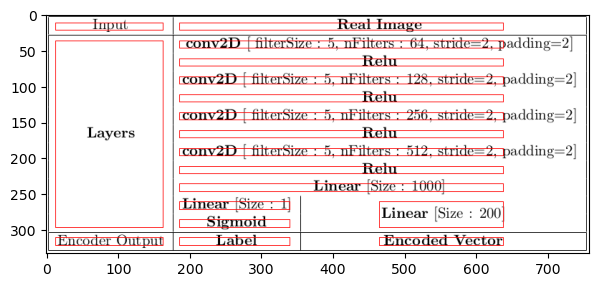

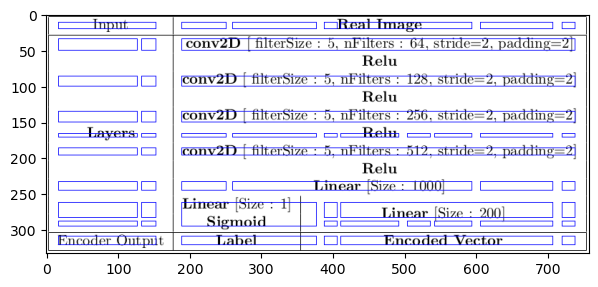

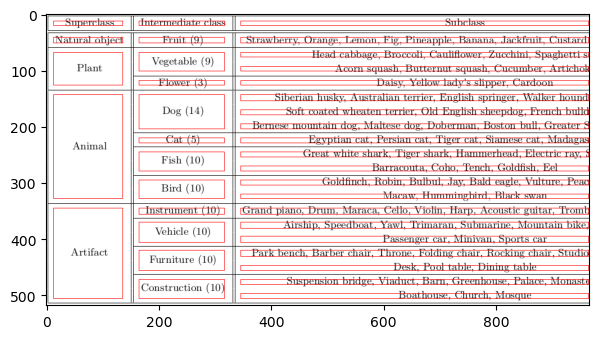

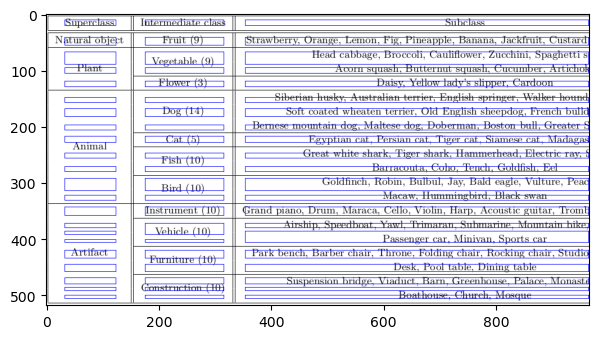

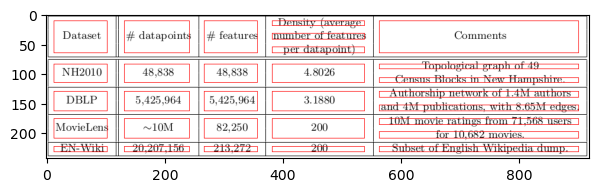

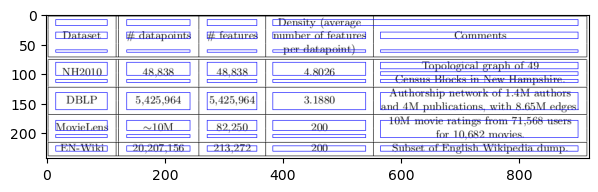

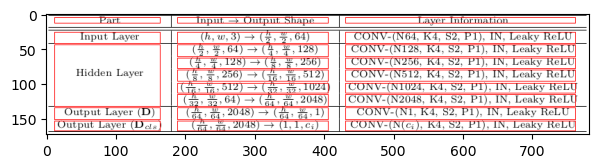

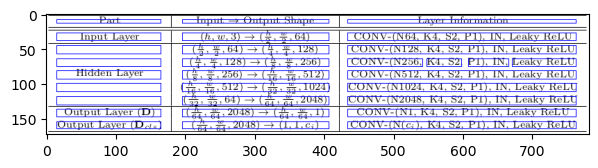

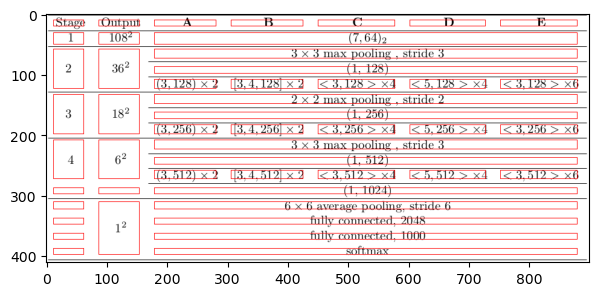

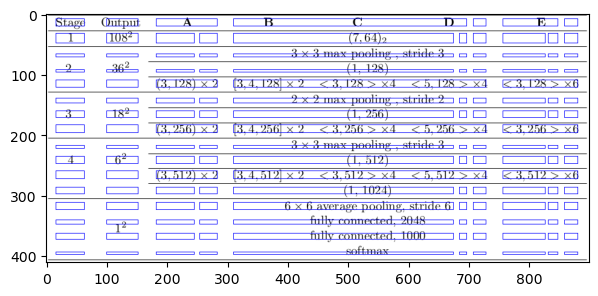

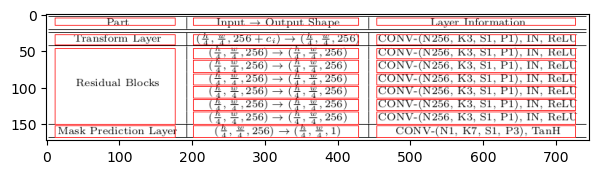

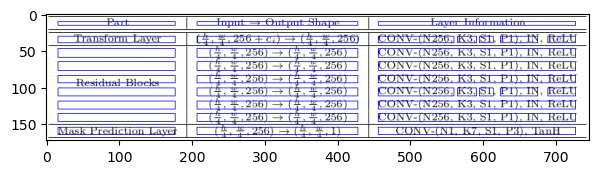

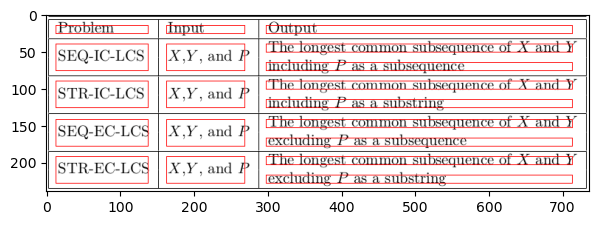

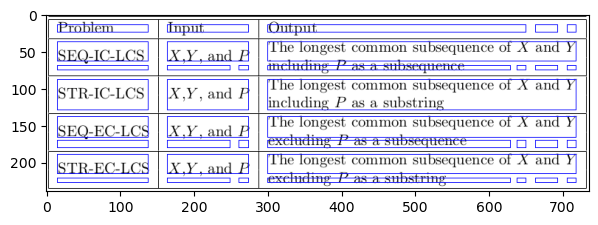

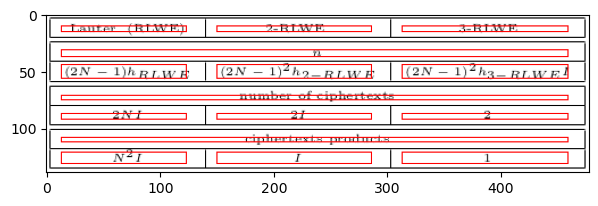

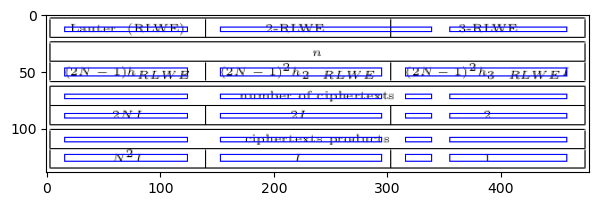

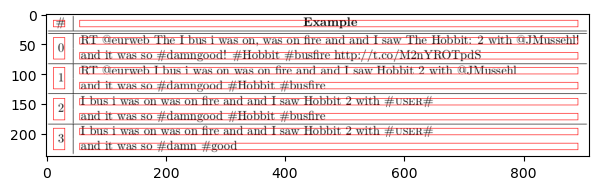

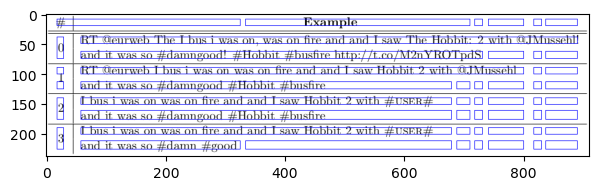

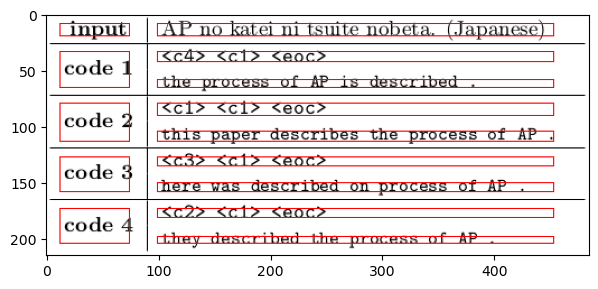

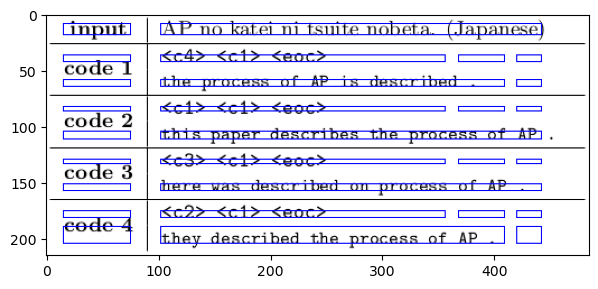

In [16]:
@torch.no_grad
def save_top_n(model, part_dir, res, save_dir, view=True):
    os.makedirs(save_dir, exist_ok=True)
    merge_labels = load_json(os.path.join(part_dir, 'label', 'merge_label.json'))
    chunk_labels = load_json(os.path.join(part_dir, 'label', 'chunk_label.json'))
    write_json(os.path.join(save_dir, 'res.json'), res)

    for ele in res:
        # img_name = ele[0]
        img_name = ele
        this_dir = os.path.join(save_dir, img_name)
        os.makedirs(this_dir, exist_ok=True)
        img = load_image(os.path.join(part_dir, 'img', f'{img_name}.png'))

        # save ground truth image
        r_gt, c_gt, R_gt, D_gt = load_merge_gt(merge_labels, img_name)
        row_gt_idxs, col_gt_idxs = borders(r_gt), borders(c_gt)
        cells_gt = get_cells(row_gt_idxs, col_gt_idxs)
        cells_merged_gt = merge_cells(cells_gt, R_gt, D_gt)
        img_gt = vis_cells(img, cells_merged_gt, 'red')
        cv.imwrite(
            os.path.join(this_dir, 'gt.png'), 
            cv.cvtColor(img_gt, cv.COLOR_RGB2BGR)
        )
        view_imgs([img_gt])
        
        # save prediction image
        img_ready = prep_image(img)
        r_pred, c_pred = model(img_ready)
        r_pred, c_pred = process_split_results(r_pred, c_pred)
        r_pred, c_pred = refine_split_results(r_pred), refine_split_results(c_pred)
        row_pred_idxs, col_pred_idxs = borders(r_pred), borders(c_pred)
        cells_pred = get_cells(row_pred_idxs, col_pred_idxs)
        
        # apply Merge heuristics
        texts_pos = chunk_labels[img_name]
        R_pred, D_pred = create_pred_matrices(row_pred_idxs, col_pred_idxs)
        rule1(cells_pred, texts_pos, R_pred, D_pred)
        rule2(cells_pred, texts_pos, R_pred, D_pred)
        if R_pred is None and D_pred is None:
            continue
        cells_merged_pred = merge_cells(cells_pred, R_pred, D_pred)
        img_pred = vis_cells(img, cells_merged_pred)
        cv.imwrite(
            os.path.join(this_dir, 'pred.png'), 
            cv.cvtColor(img_pred, cv.COLOR_BGR2RGB)
        )
        view_imgs([img_pred])

# save_top_n(model, val_dir, val_res, os.path.join(SAVE_PATH, 'top_n_val'))
save_top_n(model, train_dir, names, os.path.join(SAVE_PATH, 'entire-process'))